#Implementation of Ablang from Deane lab.
t-SNE analysis of antibodies to replicate findings from ablang paper

In [1]:
#@title Mount drive and load libraries { display-mode: "form" }
%%capture
!pip3 install torch transformers scikit-learn
!python -m pip install ankh
!pip install umap-learn[plot]

import os
from google.colab import drive
import torch
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
import umap
import seaborn as sns, matplotlib.pyplot as plt
import pandas as pd, numpy as np
import re

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/notebooks'
os.chdir(path)

from plm_manipulation import start_ablang, process_seqs, batch_embed, redux_fit

In [ ]:
model, tokenizer = start_ablang('AbLang_heavy')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_human_paired_seqs.csv', dtype={'Run':np.str_}, index_col=0)

In [3]:
tensor_df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230809_ablang_tensor_10000.csv', index_col=0)

In [ ]:
sequences = df.iloc[10000:50000]
tensor_df = batch_embed(df=sequences, prot_col='sequence_alignment_aa_heavy', seq_id='seq_id', batch_size=100, model=model, tokenizer=tokenizer)

In [ ]:
tensor_df.to_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230810_ablang_tensor_40000.csv')

In [ ]:
sequences.columns

Index(['Unnamed: 1', 'sequence_id_heavy', 'ANARCI_status_heavy',
       'sequence_heavy', 'sequence_alignment_aa_heavy', 'v_call_heavy',
       'd_call_heavy', 'j_call_heavy', 'sequence_id_light',
       'ANARCI_status_light', 'sequence_light', 'v_call_light', 'j_call_light',
       'sequence_alignment_aa_light', 'Run', 'seq_id', 'scfv'],
      dtype='object')

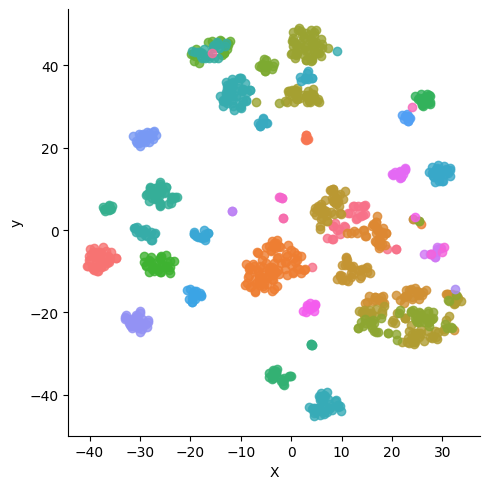

In [ ]:
new_df = redux_fit(model=TSNE, components=2, randstate=42, data=tensor_df.iloc[:, :-1])

sub = df.iloc[0:1000]
new_df['cluster'] = sub['v_call_heavy'].apply(lambda x: x.split('*')[0])

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}  #Adjust the 's' value to control point size

plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(df.iloc[0:10000]['v_call_heavy'])

def cluster_purity(y_true, y_pred):
    confomat = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-confomat)
    return confomat[row_ind, col_ind].sum() / np.sum(confomat)

n_clusters = [32,34,36,38,40,42,44]
cluster_purities = []

tsne_embedding = TSNE(n_components=2, random_state=42)
redux = tsne_embedding.fit_transform(tensor_df.iloc[:, :-1])

for cluster in n_clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=10)
  kmeans.fit(redux)
  labels = kmeans.labels_
  purity = cluster_purity(y_true=numeric_labels, y_pred=labels)
  cluster_purities.append(purity)

print(cluster_purities)

[0.7059, 0.7018, 0.7195, 0.7619, 0.7108, 0.7068, 0.7166]


In [ ]:
new_df = redux_fit(model=umap.UMAP, components=2, randstate=42, data=tensor_df.iloc[:,:-1])

sub = df.iloc[0:10000]
new_df['cluster'] = sub['v_call_heavy'].apply(lambda x: x.split('*')[0])

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}  # Adjust the 's' value to control point size

plt.show()

In [ ]:
n_clusters = [32,34,36,38,40,42,44]
cluster_purities = []

umap_embedding = umap.UMAP(n_components=2, random_state=42)
redux = umap_embedding.fit_transform(tensor_df.iloc[:, :-1])

for cluster in n_clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=10)
  kmeans.fit(redux)
  labels = kmeans.labels_
  purity = cluster_purity(y_true=numeric_labels, y_pred=labels)
  cluster_purities.append(purity)

print(cluster_purities)

[0.7189, 0.7236, 0.7172, 0.7226, 0.7521, 0.7527, 0.7609]


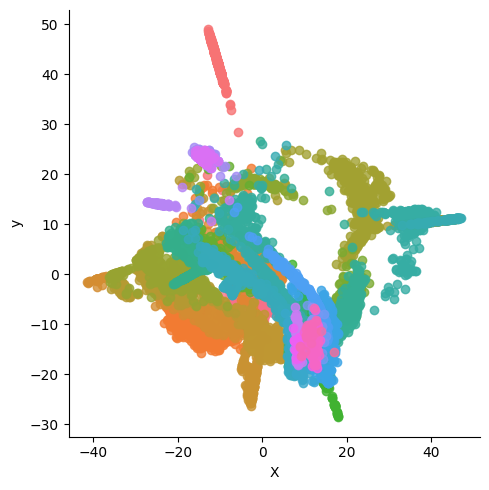

In [ ]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

X = tensor_df.iloc[:, :-1]

new_df = redux_fit(model=Isomap, components=2, randstate=42, data=X)
sub = df.iloc[0:10000]
new_df['cluster'] = sub['v_call_heavy'].apply(lambda x: x.split('*')[0])

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}

plt.show()

In [4]:
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

n_clusters = [32,34,36,38,40,42,44]
cluster_purities = []

X = tensor_df.iloc[:, :-1]
isomap_embedding = Isomap(n_components=2)
redux = isomap_embedding.fit_transform(X)

for cluster in n_clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=10)
  kmeans.fit(redux)
  labels = kmeans.labels_
  purity = cluster_purity(y_true=numeric_labels, y_pred=labels)
  cluster_purities.append(purity)

print(cluster_purities)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 19 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)


[0.4459, 0.44, 0.4441, 0.4327, 0.4168, 0.4161, 0.4262]
